In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.nn import BatchNorm2d
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# img[channel] = ( img[channel] - mean[channel] ) / std[channel]
mn, std = 0.1307, 0.3081

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (mn,),
        (std,)
    )
])

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(root = "./",
                                        train = True,
                                        transform = transform,
                                        target_transform = None,
                                        download = True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15995225.02it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270025.66it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5048632.30it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7891914.11it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [5]:
test_dataset = torchvision.datasets.FashionMNIST(root = "./",
                                        train = False,
                                        transform = transform,
                                        target_transform = None,
                                                 download = True)

In [6]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [7]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [8]:
sample_data = train_dataset[1][0].squeeze().numpy()
sample_data_label = train_dataset[1][1]

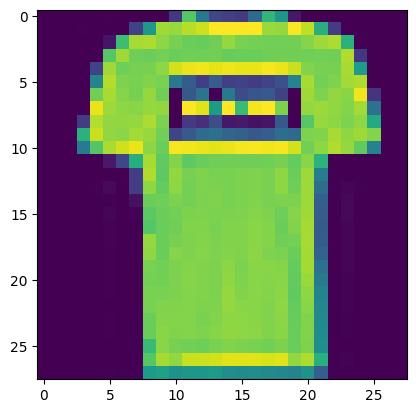

In [9]:
plt.imshow(sample_data * std + mn)

In [10]:
sample_data_label

0

In [11]:
batch_size = 32
epochs = 10

In [12]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [13]:
print(f'There are {len(train_dataset)} images in the training set')
print(f'There are {len(test_dataset)} images in the test set')
print(f'There are {len(train_loader)} batches in the train loader')
print(f'There are {len(test_loader)} batches in the testloader')

There are 60000 images in the training set
There are 10000 images in the test set
There are 1875 batches in the train loader
There are 313 batches in the testloader


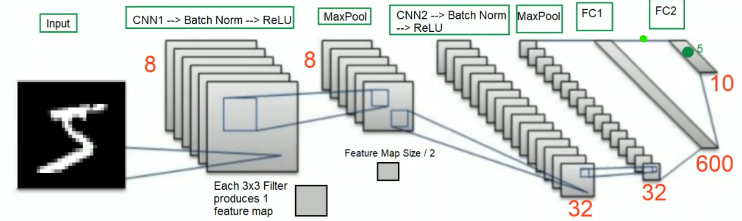

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        # apply convolution, the
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8,
                           kernel_size=3, stride=1,
                           padding=1, bias=True)
        self.bn1 = BatchNorm2d(num_features=8, eps=1e-05,
                               momentum=0.1, affine=True)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=None)

        # level 2

        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32,
                           kernel_size=5, stride=1, padding=2,bias=True)
        self.bn2 = BatchNorm2d(num_features=32, eps=1e-05,
                               momentum=0.1, affine=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=None)
        self.fc = nn.Linear(in_features=1568, out_features=600,
                            bias=True)
        self.dropout = nn.Dropout(p=0.2)
        self.output = nn.Linear(in_features=600, out_features=10)

    def forward(self,x):
        # level 1
        out = self.cnn1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool1(out)

        # level 2
        out = self.cnn2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.maxpool2(out)

        out = out.view(-1,1568)

        # fc
        out = self.fc(out)
        out = self.relu(out)
        out= self.dropout(out)
        out = self.output(out)

        return out

In [15]:
model = CNN()

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [17]:
device

device(type='cuda')

In [18]:
model = model.to(device)

In [19]:
model

CNN(
  (cnn1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=600, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=600, out_features=10, bias=True)
)

In [20]:
# define loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
itr = 0
correct = 0

for i,(input,label) in enumerate(train_loader):

      if itr == 1:
        break

      if device == torch.device("cuda"):
          input = input.to(device)
          label = label.to(device)

      print(f'Input Shape: {input.shape}') # In PyTorch, when propogating a tensor thorugh network, it has to be 4-dim [Batch, Channel, Height, Width] - NCHW
      print(f'Label Shape: {label.shape}')

      output = model(input)

      print(f'Output Shape: {output.shape}')
      print(f'Output: {output}')

      _, pred = torch.max(output,-1)
      print(f'Prediction Shape: {pred.shape}')
      print(f'Prediction: {pred}')

      correct = (pred == label).sum()
      wrong = (pred != label).sum()

      print(f'Correct: {correct}')
      print(f'Wrong: {wrong}')

      loss = loss_fn(output, label)
      print(f'Loss: {loss.item()}')

      itr += 1

Input Shape: torch.Size([32, 1, 28, 28])
Label Shape: torch.Size([32])
Output Shape: torch.Size([32, 10])
Output: tensor([[-3.5250e-01, -3.6208e-01, -6.1793e-02,  5.5547e-02,  9.8048e-02,
          1.0805e-01,  1.1645e-01,  2.5666e-01, -2.3386e-01,  7.2155e-02],
        [ 2.2895e-02,  3.4459e-01, -2.8289e-01, -1.2512e-01,  2.2199e-01,
          4.8119e-01,  6.4973e-02,  2.9393e-01, -6.5544e-01, -3.4078e-01],
        [-9.2424e-02,  5.2985e-01, -1.0163e-01,  8.6941e-02, -9.7650e-02,
          4.1308e-01,  3.2832e-01,  1.7334e-01, -3.0738e-01, -1.8186e-01],
        [ 1.4623e-01,  2.5781e-01, -1.7497e-01,  1.2417e-01,  6.6572e-01,
          1.5540e-01, -7.0538e-03,  1.8668e-01, -6.7880e-01, -3.7172e-01],
        [-4.4296e-02,  1.9691e-01, -3.0984e-01, -1.0278e-01,  4.9120e-02,
          5.7907e-01, -1.4340e-02,  5.4179e-02, -3.0331e-01,  1.2673e-01],
        [-1.1733e-01, -1.6179e-01, -8.6536e-02,  1.6871e-01,  1.4622e-01,
          1.4945e-01,  2.0462e-01,  2.0857e-01, -2.9395e-01,  1.835

In [22]:
epochs = 10

train_acc, test_acc = list(), list()
train_loss, test_loss = list(), list()

for epoch in tqdm(range(epochs)):
  correct = 0
  itrs = 0
  itr_loss = 0.0

  model.train() # as BN and dropout are present and they act differently for train and test

  for i,(input,label) in enumerate(train_loader):

      if device == torch.device("cuda"):
          input = input.to(device)
          label = label.to(device)

      optimizer.zero_grad() # clear the accumulated gradients

      output = model(input) # perform forward propogation

      loss = loss_fn(output, label) # compute loss
      itr_loss += loss.item()
      loss.backward() # perform backpropogation

      optimizer.step() # update weights (kernel elements in CNN)

      _, pred = torch.max(output,-1)

      correct += (pred == label).sum().item()


      itrs+=1

  train_loss.append(itr_loss/itrs)
  train_acc.append(correct/len(train_dataset))

  # test the model

  model.eval()

  correct = 0
  itrs = 0
  itr_loss = 0.0

  for i,(input,label) in enumerate(test_loader):

      if device == torch.device("cuda"):
          input = input.to(device)
          label = label.to(device)

      output = model(input)

      loss = loss_fn(output, label)
      itr_loss += loss.item()

      _, pred = torch.max(output,-1)

      correct += (pred == label).sum().item()

      itrs += 1

  test_loss.append(itr_loss/itrs)
  test_acc.append(correct/len(test_dataset))

  print(f'\nEpoch {epoch+1}/{epochs}, Training Loss: {train_loss[-1]:.3f}, Training Accuracy: {train_acc[-1]:.3f}, Testing Loss: {test_acc[-1]:.3f}, Testing Acc: {test_acc[-1]:.3f}')

 10%|█         | 1/10 [00:20<03:02, 20.28s/it]


Epoch 1/10, Training Loss: 0.406, Training Accuracy: 0.851, Testing Loss: 0.876, Testing Acc: 0.876


 20%|██        | 2/10 [00:40<02:41, 20.23s/it]


Epoch 2/10, Training Loss: 0.279, Training Accuracy: 0.897, Testing Loss: 0.897, Testing Acc: 0.897


 30%|███       | 3/10 [01:00<02:21, 20.27s/it]


Epoch 3/10, Training Loss: 0.236, Training Accuracy: 0.912, Testing Loss: 0.908, Testing Acc: 0.908


 40%|████      | 4/10 [01:21<02:02, 20.35s/it]


Epoch 4/10, Training Loss: 0.206, Training Accuracy: 0.923, Testing Loss: 0.913, Testing Acc: 0.913


 50%|█████     | 5/10 [01:41<01:41, 20.26s/it]


Epoch 5/10, Training Loss: 0.182, Training Accuracy: 0.932, Testing Loss: 0.916, Testing Acc: 0.916


 60%|██████    | 6/10 [02:01<01:21, 20.29s/it]


Epoch 6/10, Training Loss: 0.158, Training Accuracy: 0.940, Testing Loss: 0.908, Testing Acc: 0.908


 70%|███████   | 7/10 [02:30<01:09, 23.18s/it]


Epoch 7/10, Training Loss: 0.139, Training Accuracy: 0.948, Testing Loss: 0.914, Testing Acc: 0.914


 80%|████████  | 8/10 [02:50<00:44, 22.10s/it]


Epoch 8/10, Training Loss: 0.121, Training Accuracy: 0.955, Testing Loss: 0.920, Testing Acc: 0.920


 90%|█████████ | 9/10 [03:10<00:21, 21.40s/it]


Epoch 9/10, Training Loss: 0.103, Training Accuracy: 0.962, Testing Loss: 0.918, Testing Acc: 0.918


100%|██████████| 10/10 [03:30<00:00, 21.05s/it]


Epoch 10/10, Training Loss: 0.094, Training Accuracy: 0.964, Testing Loss: 0.922, Testing Acc: 0.922


In [23]:
torch.save(model.state_dict(),'CNN_FashionMNIST.pt')

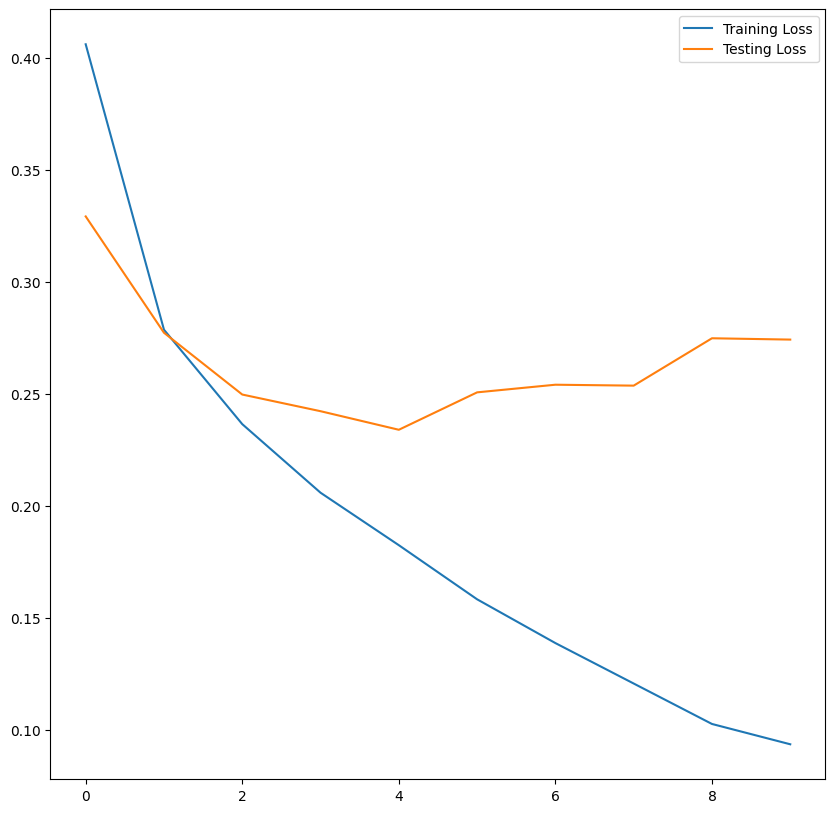

In [24]:
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

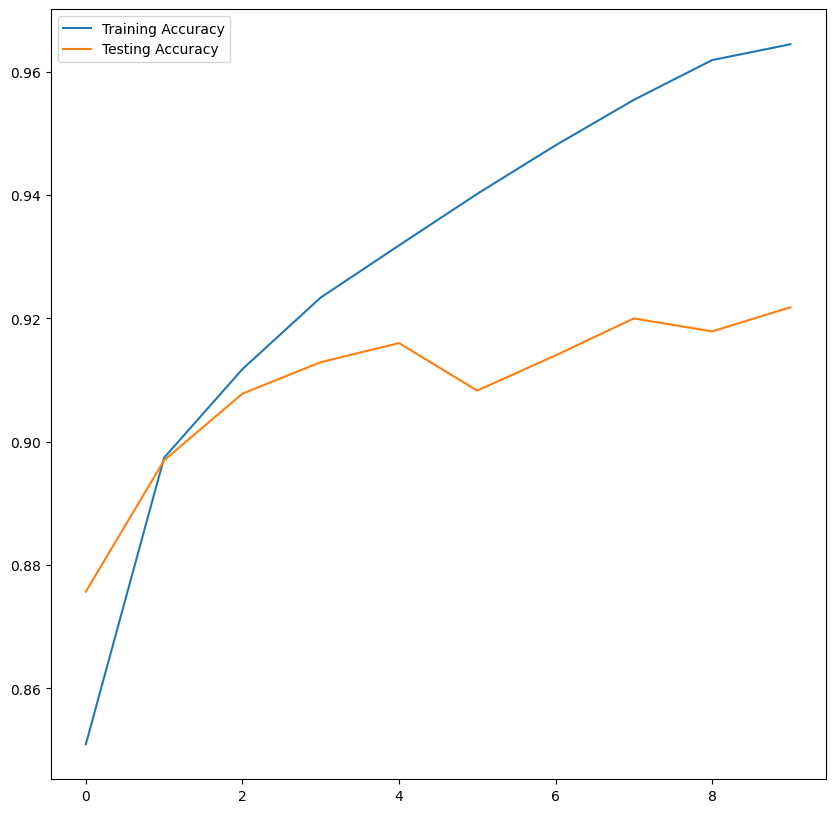

In [25]:
f = plt.figure(figsize=(10, 10))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.legend()
plt.show()

In [26]:
model.load_state_dict(torch.load('CNN_FashionMNIST.pt'))

<All keys matched successfully>

In [27]:
model

CNN(
  (cnn1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=600, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=600, out_features=10, bias=True)
)